In [1]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install -U kaleido


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import random

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel

from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
cars_df = pd.read_csv('data/vehicles.csv')
cars_df.shape

(426880, 18)

# Data integrity validation
First step in validating the integrity of data is to identify the scope and enamority of null values for each feature.

The following section counts the NaN values for each feature, puts in a '**null_df**' data frame.

In [5]:
null_df = pd.DataFrame(cars_df.isna().sum(axis = 0), columns = ['null_count'])
null_df

,null_count
id,0
region,0
price,0
year,1205
manufacturer,17646
model,5277
condition,174104
cylinders,177678
fuel,3013
odometer,4400


# Data Enrichment Strategies
Most strategies to fill the Null Value columns involve filling in with mean/median or mode if the features are of numerical types. We can also use interpolation techniques for numerical type  columns.

Since almost all the features with large Null values are categorical type features, we could use the following strategies


*   Drop if the column is not significant for inference.
*   Use K-Nearest Neighbors Imputation

*   Fill with dominant category type.
*   Introduce a new 'Default/Unknown' category and fill in Null values with it.

One of these strategies can be used for a given feature based on the categorical value distribution.










In [6]:
cars_df['condition'].value_counts(), cars_df['cylinders'].value_counts(), cars_df['drive'].value_counts(), cars_df['size'].value_counts(), cars_df['paint_color'].value_counts()

(condition
 good         121456
 excellent    101467
 like new      21178
 fair           6769
 new            1305
 salvage         601
 Name: count, dtype: int64,
 cylinders
 6 cylinders     94169
 4 cylinders     77642
 8 cylinders     72062
 5 cylinders      1712
 10 cylinders     1455
 other            1298
 3 cylinders       655
 12 cylinders      209
 Name: count, dtype: int64,
 drive
 4wd    131904
 fwd    105517
 rwd     58892
 Name: count, dtype: int64,
 size
 full-size      63465
 mid-size       34476
 compact        19384
 sub-compact     3194
 Name: count, dtype: int64,
 paint_color
 white     79285
 black     62861
 silver    42970
 blue      31223
 red       30473
 grey      24416
 green      7343
 custom     6700
 brown      6593
 yellow     2142
 orange     1984
 purple      687
 Name: count, dtype: int64)

# Data Imputation Strategy
Based on the data values distribution for each column, here're the set of strategies selected to enrich the data

| Column | Strategy|
| --- | --- |
| VIN | Drop |
| condition | Most Frequest Value Imputation |
| drive | Fill Unknown |
| size | Fill Unknonwn |


In [7]:
cars_df['condition'].fillna(cars_df['condition'].mode()[0], inplace=True)
cars_df['condition'].isna().sum()

0

In [8]:
cars_df['drive'].fillna('Unknown', inplace=True)
cars_df['size'].fillna('Unknown', inplace=True)
cars_df.drop(['VIN', 'fuel'], axis = 1, inplace=True)
cars_df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,odometer,title_status,transmission,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,good,NaN,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,good,NaN,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,good,NaN,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,good,NaN,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,good,NaN,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,nc


# Data enrichment with interpolation
This strategy is to fillin the NaN values with a random yet uniform distribution of values. The goal with this strategy is to maintain the same mix of values after the interpolation.

In [9]:
def interpolate_categorical(df, column):
    """Fills missing values in a categorical column by random sampling
    from the existing distribution.
    """
    existing_values = df[column].dropna()
    missing_indices = df[column].isna()
    df.loc[missing_indices, column] = np.random.choice(existing_values, size=missing_indices.sum())
    return df

# Interpolate 'cylinders' and 'paint_color'
cars_df = interpolate_categorical(cars_df, 'cylinders')
cars_df = interpolate_categorical(cars_df, 'paint_color')
cars_df.head()


,id,region,price,year,manufacturer,model,condition,cylinders,odometer,title_status,transmission,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,good,6 cylinders,NaN,NaN,NaN,Unknown,Unknown,NaN,grey,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,good,6 cylinders,NaN,NaN,NaN,Unknown,Unknown,NaN,grey,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,good,8 cylinders,NaN,NaN,NaN,Unknown,Unknown,NaN,blue,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,good,4 cylinders,NaN,NaN,NaN,Unknown,Unknown,NaN,white,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,good,4 cylinders,NaN,NaN,NaN,Unknown,Unknown,NaN,green,nc


In [10]:
cars_df.isna().sum(axis = 0)

id                  0
region              0
price               0
year             1205
manufacturer    17646
model            5277
condition           0
cylinders           0
odometer         4400
title_status     8242
transmission     2556
drive               0
size                0
type            92858
paint_color         0
state               0
dtype: int64

# Data Enrichment with feature mapping
A significant number of values are missing for **manufacturer** feature. This feature values can be filled by building a mapping between the model and the manufacturer.

Idea is to fill in the missing manufacturer items with mapped manufacturer if **model** is known and if there's a mapping between **model** and **manufacturer**.

In [11]:
# Extract manufacturer and model information
manufacturer_model_mapping = cars_df[['model', 'manufacturer']].drop_duplicates().sort_values(by=['model', 'manufacturer']).dropna()

# Create a dictionary for easy lookup
mapping_dict = manufacturer_model_mapping.groupby('model')['manufacturer'].apply(list).to_dict()

In [12]:
def fill_manufacturer_from_model(df, mapping):
    """Fills NaN values in the 'manufacturer' column using the provided model-to-manufacturer mapping."""
    for index, row in df.iterrows():
        if pd.isna(row['manufacturer']) and not pd.isna(row['model']):
          model = row['model']
          if model in mapping.keys():
            df.loc[index, 'manufacturer'] = mapping[model][0]
    return df

cars = fill_manufacturer_from_model(cars_df, mapping_dict)
cars.isna().sum(axis= 0)

id                  0
region              0
price               0
year             1205
manufacturer    16847
model            5277
condition           0
cylinders           0
odometer         4400
title_status     8242
transmission     2556
drive               0
size                0
type            92858
paint_color         0
state               0
dtype: int64

# Clean up data
With data enriched to optimal level, the next step is to drop the remaining null items.

This wouldn't compromise data integrity.

In [13]:
cars.dropna(inplace=True)
cars.isna().sum(axis= 0)

id              0
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

In [14]:
cars.head()

,id,region,price,year,manufacturer,model,condition,cylinders,odometer,title_status,transmission,drive,size,type,paint_color,state
27,7316814884,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,57923.0,clean,other,Unknown,Unknown,pickup,white,al
28,7316814758,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,71229.0,clean,other,Unknown,Unknown,pickup,blue,al
29,7316814989,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,19160.0,clean,other,Unknown,Unknown,pickup,red,al
30,7316743432,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,41124.0,clean,other,Unknown,Unknown,pickup,red,al
31,7316356412,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,128000.0,clean,automatic,rwd,full-size,truck,black,al


# Data Development and Validation split

One of the mosst significant steps in a machine learning project is to split the data into training and validation data sets. We use a method provided by scikit-learn package to split the data set.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(cars.drop('price', axis=1), cars.price, test_size= 0.3, random_state = 42)
X_train.shape, X_test.shape

((216068, 15), (92601, 15))

In [16]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 308669 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            308669 non-null  int64  
 1   region        308669 non-null  object 
 2   price         308669 non-null  int64  
 3   year          308669 non-null  float64
 4   manufacturer  308669 non-null  object 
 5   model         308669 non-null  object 
 6   condition     308669 non-null  object 
 7   cylinders     308669 non-null  object 
 8   odometer      308669 non-null  float64
 9   title_status  308669 non-null  object 
 10  transmission  308669 non-null  object 
 11  drive         308669 non-null  object 
 12  size          308669 non-null  object 
 13  type          308669 non-null  object 
 14  paint_color   308669 non-null  object 
 15  state         308669 non-null  object 
dtypes: float64(2), int64(2), object(12)
memory usage: 40.0+ MB


# Data Transformation
Used cars data comprises of a large number of categorical type features. Hence preprocessing of used cars features use **Ordinal Encoder**.

The following features are encoded with ordinal encoder.
*   model
*   manufacturer
*   region
*   state
*   cylinders
*   drive
*   size
*   type
*   transmission
*   condition
*   title_status
*   paint_color

In [17]:
encoder_model= OrdinalEncoder(categories= [cars.model.unique().tolist()])
encoder_state = OrdinalEncoder(categories= [cars.state.unique().tolist()])
encoder_region = OrdinalEncoder(categories= [cars.region.unique().tolist()])
preprocessor = ColumnTransformer(
    transformers=[
        ('models', encoder_model, ['model']),
        ('manufacturer', OrdinalEncoder(), ['manufacturer']),
        ('region', encoder_region, ['region']),
        ('state', encoder_state, ['state']),
        ('type', OrdinalEncoder(), ['cylinders', 'drive', 'size', 'type', 'transmission']),
        ('condition', OrdinalEncoder(), ['condition', 'title_status']),
        ('paint_color', OrdinalEncoder(), ['paint_color'])
    ],
    remainder='passthrough'  # To keep the other columns as is
)

# Feature Selection
Feature selection is the process of reducing dimensionality so as to achieve
*   Improved Model Performance
*   Addressing curse of Dimensionality
*   Cost & Efficiency
The cost of training increases exponentially with higher dimensionality of the data. Hence one of the important step in data analysis stage of M/L projects is to identify and remove less significant features with respect to prediction.

We use a couple of methods for feature selection and try to compare these methods.
*   Polynomial Feature Selection
*   Sequential Feature Selection
*   SelectFromModel with Ridge Estimator

In [18]:
sample = cars.sample(n = 30_000, random_state = 42)
S_train, S_test, t_train, t_test = train_test_split(sample.drop('price', axis=1), sample.price, test_size= 0.3, random_state = 42)
S_train.shape, S_test.shape, t_train.shape, t_test.shape

((21000, 15), (9000, 15), (21000,), (9000,))

# Downsizing for Polynomial Feature selection
Compute requirements for Polynomial feature fit increases exponentially with each additional degree. We downsized the data to limit the computational power requirements.

We sampled 20K items from vehicle data and we could scale up to 6 degrees with 20K items with compute setup.

In [19]:
train_mses = []
test_mses = []
best_model = None #placeholder for best model
best_mse = np.inf
for i in range(1, 5):
    pipe = Pipeline([('preprocessor', preprocessor),
                     ('scaler', StandardScaler()),
                      ('poly', PolynomialFeatures(degree = i, include_bias = False)),
                     ('regression',  LinearRegression())])
    pipe.fit(S_train, t_train)
    train_mses.append(mean_squared_error(t_train, pipe.predict(S_train)))
    mse = mean_squared_error(t_test, pipe.predict(S_test))
    test_mses.append(mse)
    if (mse < best_mse):
      best_mse = mse
      best_model = pipe

best_model.named_steps['regression'].coef_

array([ 6.94156158e+02, -3.57346107e+02, -3.85946239e+02,  2.11589652e+02,
        2.15417950e+03, -3.30755865e+03, -9.22196084e+02, -3.12403415e+02,
        1.08771899e+03,  1.27783694e+03,  3.52723882e+02,  4.85234324e+02,
       -3.25800324e+02,  7.16779516e+03, -8.73549238e+03, -1.12722294e+02,
       -1.10796113e+02,  5.12579070e+02, -3.86248384e+02,  3.42730166e+02,
       -1.32877562e+02,  7.92065349e+01,  3.21873101e+02, -2.06490384e+02,
        9.27902715e+01, -6.93857825e+01,  1.69978330e+02, -1.82106423e+02,
        1.38588047e+02, -1.89865067e+02,  4.12998088e+02,  4.01226141e+02,
       -4.85124623e+02,  2.66809685e+01, -6.09326986e+00,  1.23495571e+01,
       -4.70460482e+01, -1.71507010e+02, -1.37275415e+02,  7.46305776e+01,
        4.22903110e+01,  1.74900154e+02, -3.24347117e+02, -9.11452996e+01,
       -1.59101642e+02,  1.07339953e+03, -8.69196451e+01, -4.55662922e+02,
        2.60885597e+02,  1.64875124e+02, -6.94864872e+02,  8.48055311e+02,
       -7.04945447e+01, -

# Feature selection
Based on the coefficients in the regression step and featurenames from the 'polynomial feature' fit step, we can derive the most signficant features that influence the prediction. This model identifies the following 2nd-order features as signficant.
* condition^2
* year state
* manufacturer state
* paint_color
* state

In [20]:
coefs = best_model.named_steps['regression'].coef_
top_feature_indices = np.argsort(np.abs(coefs))[-5:]
feature_names = best_model.named_steps['poly'].get_feature_names_out(input_features=X_train.columns)
[feature_names[i] for i in top_feature_indices]

['condition^2', 'year state', 'manufacturer state', 'paint_color', 'state']

# Training vs Testing MSE plot

This plot identifies the training MSE vs testing MSE with respect to the 'degree' of polynomial features. Typically, test MSE start to increase exponentially after a certain degree and this is considered as optimal degree for this data set.

As the plot suggests, degree-2 seems to be the optimal degree for prediction.

The Complexity that minimized Test Error was: 2


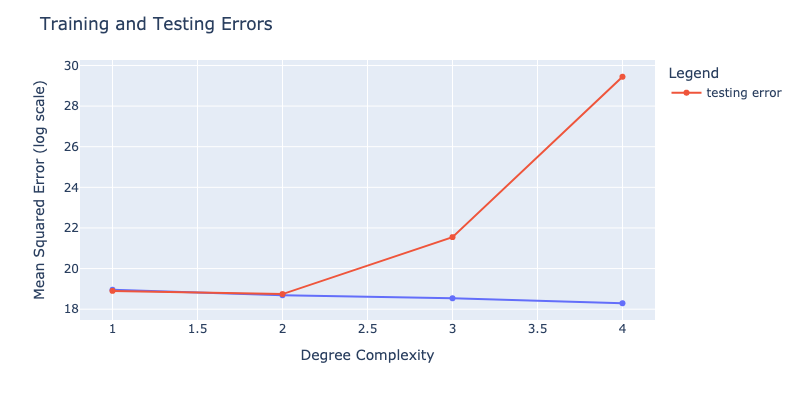

In [27]:
print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
fig = px.line(x=list(range(1, 5)), y=np.log(train_mses), markers=True, width=800, height=400)
fig.add_scatter(x=list(range(1, 5)), y=np.log(test_mses), mode='lines+markers', name='testing error')
fig.update_layout(
    title="Training and Testing Errors",
    xaxis_title="Degree Complexity",
    yaxis_title="Mean Squared Error (log scale)",
    legend_title="Legend"
)
fig.show("png")

# Evaluate Prediction

This method plots the validation data vs predicted data. This method just presents a visual representation of how predicted data varies from test data.

It doesn't measure and inform how predicted data varies from validation data.

In [35]:
def validate_model(model, X_test, y_test):
  idx = y_test.index
  df = pd.DataFrame({'y_test': np.log(y_test), 'y_pred': np.log(model.predict(X_test))})
  df_sorted = df.sort_values('y_test', ascending=False)
  df_sorted['idx'] = range(len(y_test))
  df_sorted.set_index('idx', inplace = True)

  # Plot the test data vs. predicted data
  fig = px.line(df_sorted, x= df_sorted.index, y= 'y_test', width=800, height=400)
  fig.add_scatter(x=df_sorted.index, y=df_sorted['y_pred'], mode='lines')
  fig.update_layout(xaxis_title='Transaction', yaxis_title='Predicted/Actual Price')
  fig.show("png")

# Polynomial Feature Selection & Linear Regression

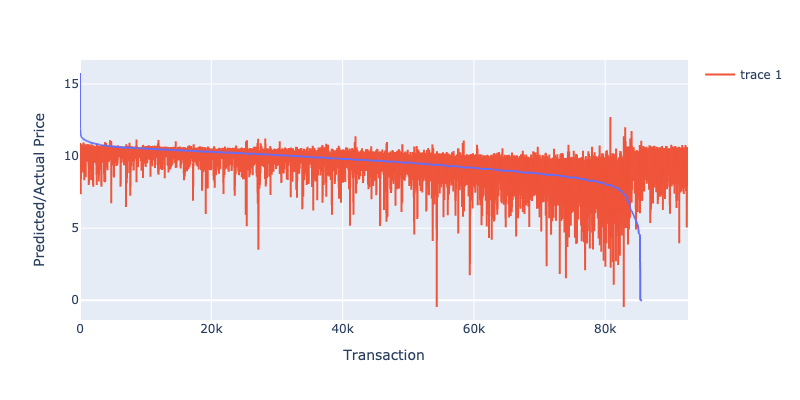

In [36]:
validate_model(best_model, X_test, y_test)

MSE

In [37]:
mse = mean_squared_error(y_test, best_model.predict(X_test))
mse

655731408.9857694

# Sequential Feature Selection
Sequential Feature Selection is type of greedy algorithm technique that targeted to improve the model performance by selecting a subset of most signifcant features from a larger set.

There are two type of selection methodologies: Forward selection starts with empty set of features and iteratively adds features that impacts most until prediction accuracy improves to the max. Backward Elimination gradually removes the features that least impacts the performance and optimal prediction accuracy is achieved.

I use Forward selection, since it's less resource intensive method. We use Ridge regression methodology since it includes regularization to address compute complexity.

This model identfies the following features
* year
* manufacturer
* odometer
* title_status
* drive
* state

In [31]:
pipe = Pipeline([('preprocessor', preprocessor),
                 ('scaler', StandardScaler()),
                 ('selector', SequentialFeatureSelector(estimator= Ridge(), n_features_to_select= 6, direction='forward')),
                 ('ridge', Ridge())])
param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}
grid = GridSearchCV(estimator = pipe, param_grid = param_dict)
grid.fit(X_train, y_train)

#mse = mean_squared_error(y_test, grid.predict(X_test))
cols = grid.best_estimator_.named_steps['selector'].get_support(indices = True)
print(grid.best_estimator_.named_steps['ridge'].coef_)
list(X_train.columns[cols])

[13243.00930865 -5508.04976433  3376.75851498 -3491.60764025
 -5996.22586193  7546.75199953]


['year', 'manufacturer', 'odometer', 'title_status', 'drive', 'state']

# Ridge Regression Model Evaluation

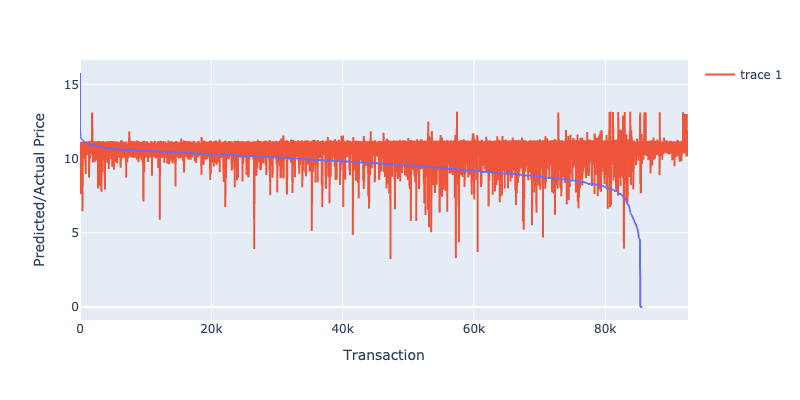

In [38]:
validate_model(grid, X_test, y_test)

# MSE

In [41]:
mse = mean_squared_error(y_test, grid.predict(X_test))
mse

6074720980.122198

# SelectFrom Model with Ridge Estimator

"Select From Model" with a Ridge estimator is a technique in machine learning that combines feature selection with the regularization benefits of Ridge regression.

It lists the selected set of significant features.
*   region
*   year
*   condition
*   model
*   type
*   paint_color

In [42]:
pipe = Pipeline([('preprocessor', preprocessor),
                 ('scaler', StandardScaler()),
    ('selector', SelectFromModel(estimator = Ridge(), max_features= 6)), ('ridge', Ridge())])
param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}
grid = GridSearchCV(estimator = pipe, param_grid = param_dict)
grid.fit(X_train, y_train)

mse = mean_squared_error(y_test, grid.predict(X_test))
cols = grid.best_estimator_.named_steps['selector'].get_support(indices = True)
print(grid.best_estimator_.named_steps['ridge'].coef_)
list(X_train.columns[cols])

[ 30093.83179356   4415.54928779  19005.92837194 -16918.04038381
 -36002.13388977 -40148.92613624]


['region', 'year', 'model', 'condition', 'type', 'paint_color']

# Select From Model with Ridge Estimator Evaluation

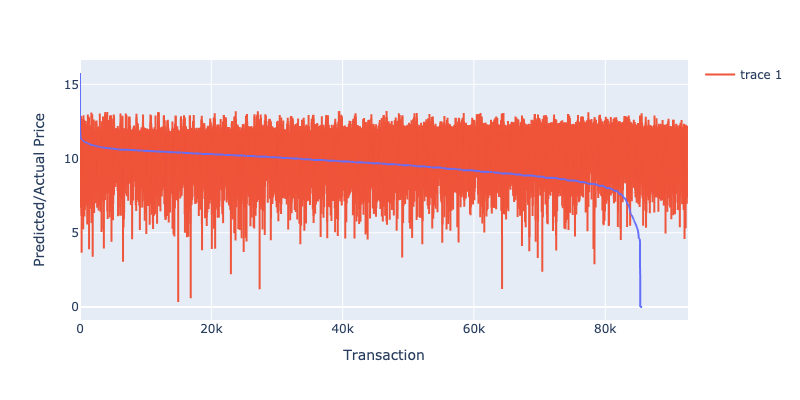

In [43]:
validate_model(grid, X_test, y_test)

# MSE

In [44]:
mse = mean_squared_error(y_test, grid.predict(X_test))
mse

6074720980.122198

# Visualizations


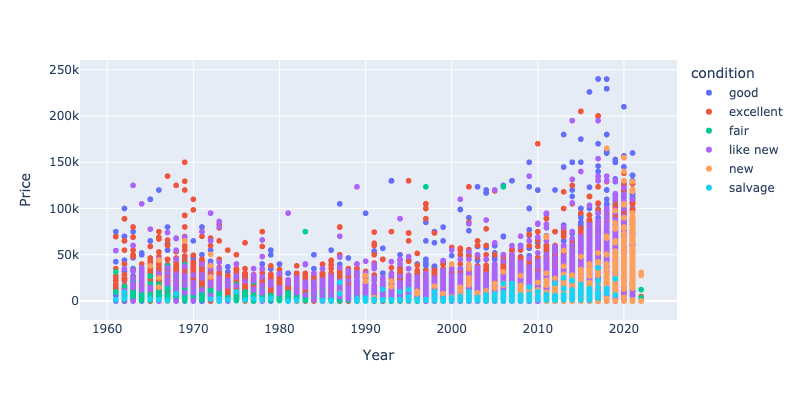

In [46]:
fig = px.scatter(data_frame= cars.query('year > 1960 and price < 250_000'), x= 'year', y = 'price', color= 'condition', width=800, height=400)
fig.update_layout(xaxis_title='Year', yaxis_title='Price')
fig.show("png")

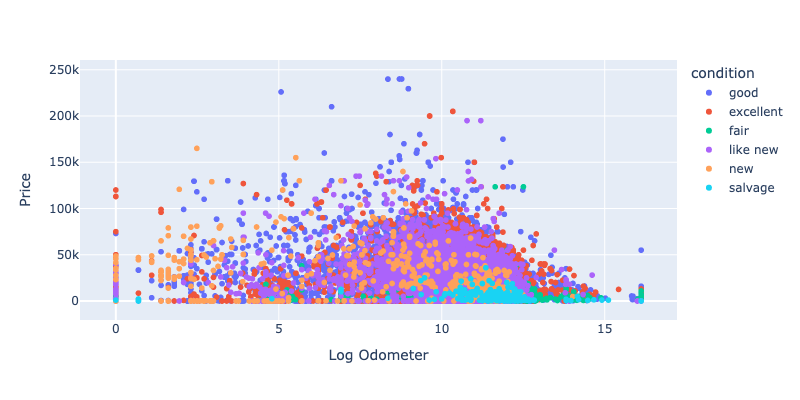

In [47]:
cars['l_odometer'] = np.log(cars['odometer'])
fig = px.scatter(data_frame= cars.query('year > 1960 and price < 250_000'), x= 'l_odometer', y = 'price', color= 'condition', width=800, height=400)
fig.update_layout(xaxis_title='Log Odometer', yaxis_title='Price')
fig.show("png")

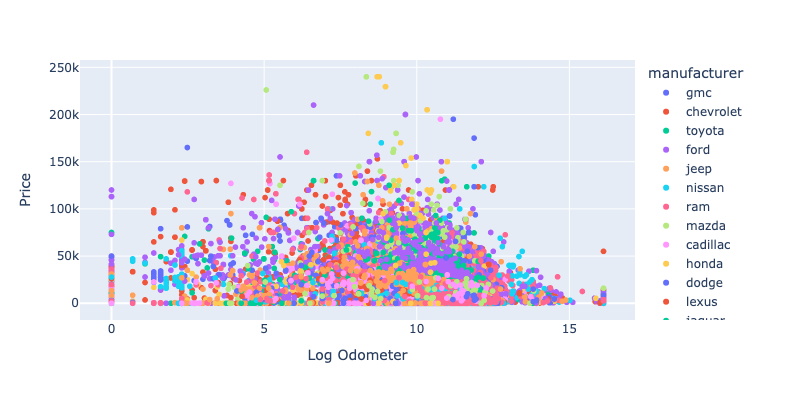

In [48]:
cars['l_odometer'] = np.log(cars['odometer'])
fig = px.scatter(data_frame= cars.query('year > 1960 and price < 250_000'), x= 'l_odometer', y = 'price', color= 'manufacturer', width=800, height=400)
fig.update_layout(xaxis_title='Log Odometer', yaxis_title='Price')
fig.show("png")

# AUDI car price trend
In this section, I intended to explore the price of used AUDI cars with respect to odometer. Logorthmic scale of odometer is chosen to better represent the distribution. The visualizations show the following trends.
* As the odometer increases, price reduces
* As the years increase (i.e. newer the car) the price increases.

In [49]:
cars['l_odometer'] = np.log(cars['odometer'])
q7 = cars.query('year > 1960 and price < 250_000 and model == "q7"')

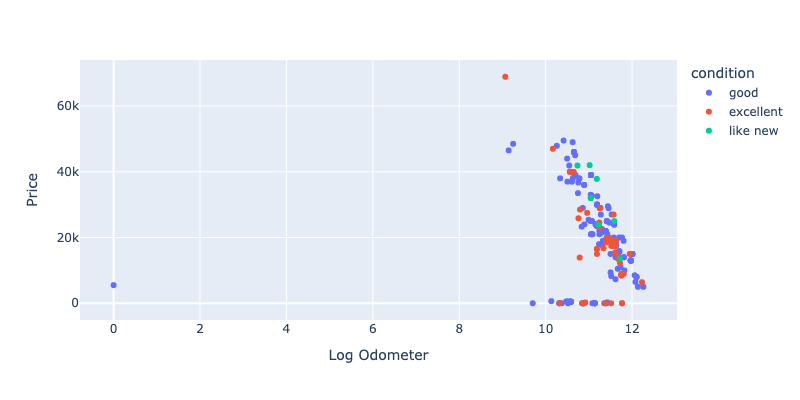

In [50]:
fig = px.scatter(data_frame= q7, x= 'l_odometer', y = 'price', color= 'condition', width=800, height=400)
fig.update_layout(xaxis_title='Log Odometer', yaxis_title='Price')
fig.show("png")

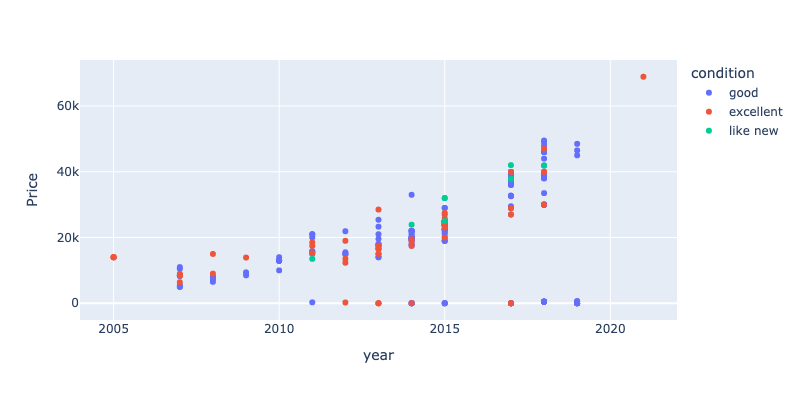

In [51]:
fig = px.scatter(data_frame= q7, x= 'year', y = 'price', color= 'condition', width=800, height=400)
fig.update_layout(xaxis_title='year', yaxis_title='Price')
fig.show("png")

# Car Model Distribution
In this section, I wanted to show visual representation of distribution of 
used cars sold by year with respect to each manufacturer and model.

Visualization shows some interesting facts (probably trivial as well). 
* Ferrari cars sold higher prices even if they are quite old as expected. 
* Pontiac and Datsun cars are sold for reasonably high price for older cars.
* Mercedes, Porshe & Ferrari sold most high end cars followed by Audi, BMW, Chevy & Ford.

In [55]:
car_models = cars.query('year > 1980 and price < 250_000').groupby(['manufacturer', 'year', 'model'])[['price']].mean().reset_index()
car_models.head()

,manufacturer,year,model,price
0,acura,1991.0,legend coupe,1000.0
1,acura,1991.0,nsx,58200.0
2,acura,1992.0,integra,3200.0
3,acura,1993.0,integra gs,1000.0
4,acura,1993.0,legend,1900.0


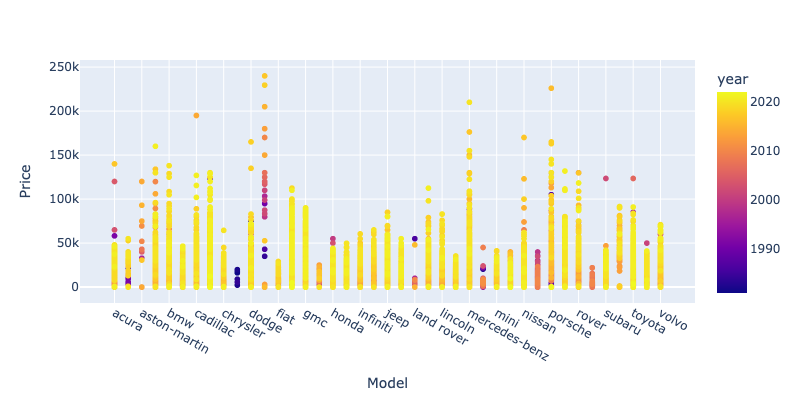

In [57]:
fig = px.scatter(car_models, x= 'manufacturer', y='price', color = 'year', width=800, height=400)
fig.update_layout(xaxis_title='Model', yaxis_title='Price')
fig.show("png")

In [61]:
cars_clean = cars.query('year > 1980 and price < 250_000')
cars_clean['l_odometer'] = np.log(cars_clean['odometer'])

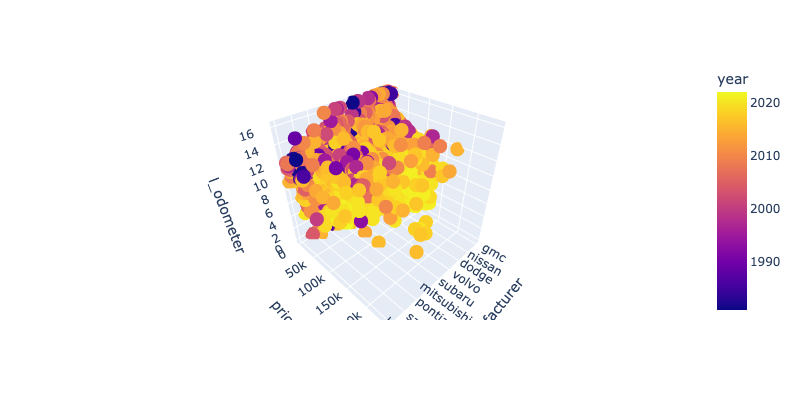

In [62]:
fig = px.scatter_3d(data_frame= cars_clean, x= 'manufacturer', y = 'price', z= 'l_odometer', 
                    color= 'year', width=800, height=400)
fig.show("png")